<a href="https://colab.research.google.com/github/ymuto0302/PJ2025/blob/main/early_stopping_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 早期停止(early stopping)のデモ

### 必要なライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### データローダーの準備

In [2]:
# データの前処理
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# CIFAR-10データセットの読み込み
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)

# 訓練データを訓練用と検証用に分割（全データの80%を訓練用、20%を検証用）
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size

# 再現性のためのシード設定
torch.manual_seed(42)
train_dataset, val_dataset = random_split(full_trainset, [train_size, val_size])

print(f'Full training samples: {len(full_trainset)}')
print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(testset)}')

# データローダーの作成
batch_size = 128  # フルデータセット用にバッチサイズを大きく設定
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]


Full training samples: 50000
Training samples: 40000
Validation samples: 10000
Test samples: 10000


### モデルの定義

In [3]:
# CNNモデルの定義
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedCNN, self).__init__()

        # 第1ブロック
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # 第2ブロック
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # 第3ブロック
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # 第4ブロック
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # 全結合層
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # 第1ブロック
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.bn1(x)
        x = self.pool(x)

        # 第2ブロック
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.bn2(x)
        x = self.pool(x)

        # 第3ブロック
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.bn3(x)
        x = self.pool(x)

        # 第4ブロック
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.bn4(x)
        x = self.pool(x)

        # Global Average Pooling
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        # 全結合層
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Patience アルゴリズムの実装

In [4]:
# 早期停止クラス : Patience アルゴリズムの実装
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

### モデル，損失関数，最適化アルゴリズム，学習率スケジューリング，早期停止の設定

In [5]:
# モデル，損失関数，最適化アルゴリズムの設定
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# コサインアニーリングスケジューラー
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# 早期停止の設定
early_stopping = EarlyStopping(patience=15, min_delta=0.001)

### モデルの学習（訓練）
このコードでは最大200エポックの学習を行うよう設定されているが，早期停止により適当なタイミングで学習が停止する。

In [6]:
# 訓練履歴を記録するリスト
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 訓練ループ
def train_model(model, trainloader, valloader, criterion, optimizer, scheduler, early_stopping, epochs=200):
    best_val_acc = 0.0

    for epoch in range(epochs):
        # 訓練フェーズ
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += targets.size(0)
            correct_train += predicted.eq(targets).sum().item()

            '''
            # プログレス表示（大きなデータセットのため）
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(trainloader)}, '
                      f'Loss: {loss.item():.4f}')
            '''

        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct_train / total_train

        # 検証フェーズ
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += targets.size(0)
                correct_val += predicted.eq(targets).sum().item()

        val_loss /= len(valloader)
        val_acc = 100. * correct_val / total_val

        # 履歴の記録
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # 学習率スケジューラーの更新
        scheduler.step()

        # 最高精度の更新
        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f'Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
              f'Best Val Acc: {best_val_acc:.2f}%, LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # 早期停止の判定
        if early_stopping(val_loss, model):
            print(f'Early stopping at epoch {epoch+1}')
            print(f'Best validation accuracy: {best_val_acc:.2f}%')
            break

    return model

# モデルの訓練
print("Starting training with full CIFAR-10 dataset...")
print("This may take a while depending on your hardware...")
model = train_model(model, trainloader, valloader, criterion, optimizer, scheduler, early_stopping)


Starting training with full CIFAR-10 dataset...
This may take a while depending on your hardware...
Epoch   1: Train Loss: 1.5761, Train Acc: 41.79%, Val Loss: 1.3742, Val Acc: 51.16%, Best Val Acc: 51.16%, LR: 0.000999
Epoch   2: Train Loss: 1.1435, Train Acc: 59.33%, Val Loss: 1.0700, Val Acc: 61.83%, Best Val Acc: 61.83%, LR: 0.000996
Epoch   3: Train Loss: 0.9447, Train Acc: 67.25%, Val Loss: 0.8352, Val Acc: 70.40%, Best Val Acc: 70.40%, LR: 0.000991
Epoch   4: Train Loss: 0.8103, Train Acc: 72.20%, Val Loss: 0.8436, Val Acc: 71.10%, Best Val Acc: 71.10%, LR: 0.000984
Epoch   5: Train Loss: 0.7294, Train Acc: 75.28%, Val Loss: 0.7343, Val Acc: 74.30%, Best Val Acc: 74.30%, LR: 0.000976
Epoch   6: Train Loss: 0.6637, Train Acc: 77.47%, Val Loss: 0.7018, Val Acc: 75.25%, Best Val Acc: 75.25%, LR: 0.000965
Epoch   7: Train Loss: 0.6131, Train Acc: 79.39%, Val Loss: 0.6392, Val Acc: 78.05%, Best Val Acc: 78.05%, LR: 0.000952
Epoch   8: Train Loss: 0.5715, Train Acc: 80.61%, Val Loss: 

### テストデータでの評価

In [7]:
# テストデータでの評価
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # クラス別精度の計算
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_loss /= len(testloader)
    test_acc = 100. * correct / total

    print(f'\nTest Results:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.2f}%')

    # クラス別精度の表示
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    print(f'\nClass-wise Accuracy:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')

    return test_acc, test_loss

# テスト評価
test_accuracy, test_loss = evaluate_model(model, testloader)



Test Results:
Test Loss: 0.3913
Test Accuracy: 90.44%

Class-wise Accuracy:
plane: 91.90%
car: 95.40%
bird: 86.50%
cat: 82.10%
deer: 91.50%
dog: 84.40%
frog: 90.90%
horse: 92.10%
ship: 94.90%
truck: 94.70%


### 損失と正解率の推移を可視化

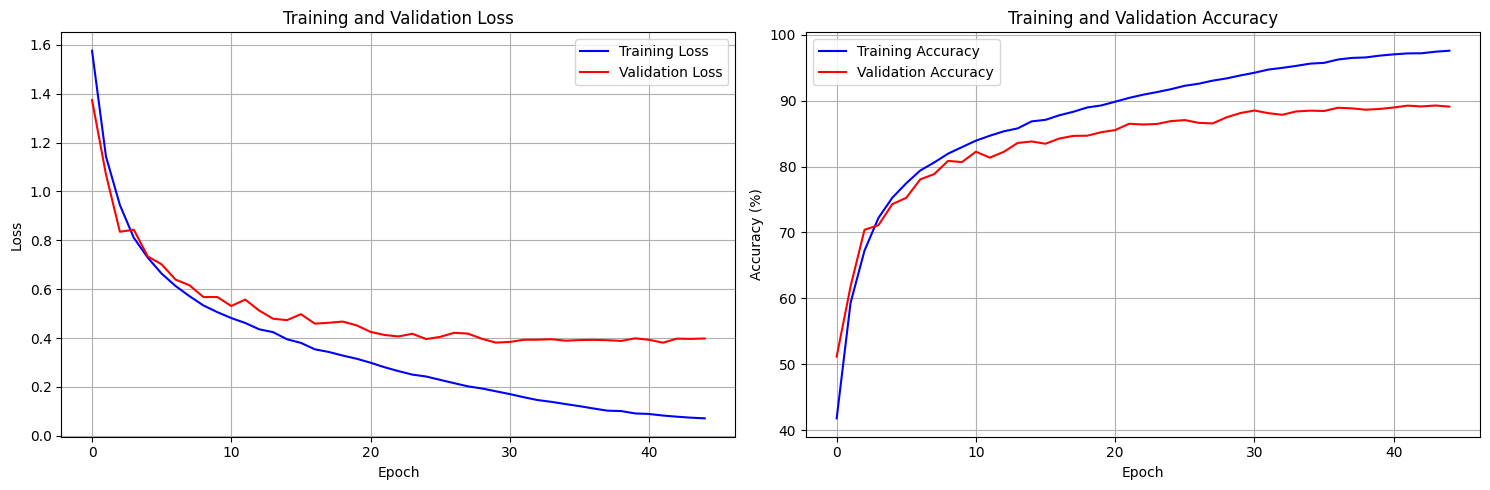


=== 実験結果のまとめ ===
使用したデータ: CIFAR-10
最終テスト精度: 90.44%
訓練エポック数: 45エポック


In [8]:
# 結果の可視化
def plot_training_history():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 損失の推移
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # 正解率の推移
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# 訓練履歴の可視化
plot_training_history()

# モデルの保存
# torch.save(model.state_dict(), 'cifar10_full_model.pth')
# print("Model saved as 'cifar10_full_model.pth'")

print(f"\n=== 実験結果のまとめ ===")
print(f"使用したデータ: CIFAR-10")
print(f"最終テスト精度: {test_accuracy:.2f}%")
print(f"訓練エポック数: {len(train_losses)}エポック")